In [28]:
import copy
import humanize
import math
import matplotlib.pyplot as plt
import os
import subprocess
import sys
import pandas as pd
import time

from ast import literal_eval
from matplotlib.ticker import FuncFormatter
from IPython.display import display, clear_output

In [2]:
# pull in our gquery module and import the config
sys.path.append('../../scripts')
os.environ['GUFI_CONFIG']='/home/jbent/GUFI/configs/jbent_home'
#os.environ['GUFI_DEBUG']='TRUE'
import gquery as gq

config=gq.query_gconfig()
nthreads=config.config['Threads']
indexroot=config.config['IndexRoot']
print(f"Using {nthreads} threads on {indexroot}")

Using 224 threads on /mnt/nvme3n1/jbent/jbent_home


In [86]:
# function to find the largest file in an index
def largest_file_size(indexroot,nthreads=nthreads,Verbose=True):
    select='size'
    tables='vrpentries'
    where=None
    (command,cstr)=gq.get_gufi_command(select=select,tables=tables,where=where,nthreads=nthreads,indexroot=indexroot)
    largest_file = gq.execute_command(command=command,command_string=cstr,aggregate_function='max',Verbose=Verbose)
    return largest_file

In [87]:
largest = largest_file_size(indexroot)
max_pow = math.ceil(math.log2(largest))
largest, max_pow

Will now execute gufi_query -S 'select size from vrpentries  ' -n 224 /mnt/nvme3n1/jbent/jbent_home.


(33878226, 26)

In [43]:
def humanize_size(size):
    h_size = humanize.naturalsize(size, binary=True, gnu=True, format='%d')
    return h_size

def get_bin_name(lower,upper):
    return f"[{humanize_size(lower)},{humanize_size(upper)})"

In [13]:
# an example sql query using CASE
'''
SELECT
  SUM(CASE WHEN stem < 100 THEN 1 ELSE 0 END) AS Count_Less_Than_100,
  SUM(CASE WHEN stem BETWEEN 100 AND 200 THEN 1 ELSE 0 END) AS Count_Between_100_And_200,
  SUM(CASE WHEN stem > 200 THEN 1 ELSE 0 END) AS Count_Greater_Than_200
FROM your_table_name;
'''

'\nSELECT\n  SUM(CASE WHEN stem < 100 THEN 1 ELSE 0 END) AS Count_Less_Than_100,\n  SUM(CASE WHEN stem BETWEEN 100 AND 200 THEN 1 ELSE 0 END) AS Count_Between_100_And_200,\n  SUM(CASE WHEN stem > 200 THEN 1 ELSE 0 END) AS Count_Greater_Than_200\nFROM your_table_name;\n'

In [19]:
# let's define our bins
bins = []
for i in range(max_pow):
    lower = 2**(i-1) if i > 0 else 0
    upper = 2**i
    bins.append((lower,upper))
    # how to make the bin name,(f"[{lower},{upper})")])
print(bins)

[(0, 1), (1, 2), (2, 4), (4, 8), (8, 16), (16, 32), (32, 64), (64, 128), (128, 256), (256, 512), (512, 1024), (1024, 2048), (2048, 4096), (4096, 8192), (8192, 16384), (16384, 32768), (32768, 65536), (65536, 131072), (131072, 262144), (262144, 524288), (524288, 1048576), (1048576, 2097152), (2097152, 4194304), (4194304, 8388608), (8388608, 16777216), (16777216, 33554432)]


In [51]:
# let's make our SQL select statement
table = "vrpentries"
cases = []
for lower,upper in bins:
    bin_name = get_bin_name(lower,upper)
    cases.append(f"SUM(CASE WHEN size >= {lower} AND size < {upper} THEN 1 ELSE 0 END) as \"{bin_name}\"")
query_middle = "\t" + ",\n\t".join(cases)
query = f"SELECT\n{query_middle}\nFROM {table};"
print(query)

SELECT
	SUM(CASE WHEN size >= 0 AND size < 1 THEN 1 ELSE 0 END) as "[0B,1B)",
	SUM(CASE WHEN size >= 1 AND size < 2 THEN 1 ELSE 0 END) as "[1B,2B)",
	SUM(CASE WHEN size >= 2 AND size < 4 THEN 1 ELSE 0 END) as "[2B,4B)",
	SUM(CASE WHEN size >= 4 AND size < 8 THEN 1 ELSE 0 END) as "[4B,8B)",
	SUM(CASE WHEN size >= 8 AND size < 16 THEN 1 ELSE 0 END) as "[8B,16B)",
	SUM(CASE WHEN size >= 16 AND size < 32 THEN 1 ELSE 0 END) as "[16B,32B)",
	SUM(CASE WHEN size >= 32 AND size < 64 THEN 1 ELSE 0 END) as "[32B,64B)",
	SUM(CASE WHEN size >= 64 AND size < 128 THEN 1 ELSE 0 END) as "[64B,128B)",
	SUM(CASE WHEN size >= 128 AND size < 256 THEN 1 ELSE 0 END) as "[128B,256B)",
	SUM(CASE WHEN size >= 256 AND size < 512 THEN 1 ELSE 0 END) as "[256B,512B)",
	SUM(CASE WHEN size >= 512 AND size < 1024 THEN 1 ELSE 0 END) as "[512B,1K)",
	SUM(CASE WHEN size >= 1024 AND size < 2048 THEN 1 ELSE 0 END) as "[1K,2K)",
	SUM(CASE WHEN size >= 2048 AND size < 4096 THEN 1 ELSE 0 END) as "[2K,4K)",
	SUM(CASE WHEN size

In [56]:
def run_gufi_query(indexroot, nthreads, create_int, insert_int, create_agg, insert_agg, select_agg, Verbose=False):
    cmd = 'gufi_query'
    command = [
        cmd,
        "-I", create_int,
        "-S", insert_int,
        "-K", create_agg,
        "-J", insert_agg,
        "-G", select_agg,
        "-n", nthreads,
        indexroot
    ]
    if Verbose:
        print(f"Running {cmd} on {indexroot} with {nthreads} threads using the following command:")
        print('\n\t'.join([line for line in command]))
    
    start_time = time.time()
    completed_process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    end_time = time.time()
    
    if completed_process.returncode != 0:
        print(f"An error occurred:\n{completed_process.stderr.decode('utf-8')}")
        return None
    else:
        output = completed_process.stdout.decode('utf-8')
        if Verbose:
            print(f"Output:\n{output}")
            print(f"Elapsed time: {(end_time - start_time)/60:.2f} minutes")
        return output

In [91]:
# a function to pull the predefined file size bins using the native gufi function
def get_bins(indexroot,Verbose=True):
    cmd = 'gufi_query'
    tab = 'vrpentries'
    itab = 'intermediate'
    atab = 'aggregate'
    
    # first we need to know the largest file, then we can create the bins for this file system
    largest = largest_file_size(indexroot)
    bins = []
    for i in range(math.ceil(math.log2(largest))):
        lower = 2**(i-1) if i > 0 else 0
        upper = 2**i
        bins.append((lower,upper))
    
    # create the shared create statement which is the same used for both int and agg
    def create_table_str(table):
        bnames = []
        for (lower,upper) in bins:
            bname = get_bin_name(lower,upper)
            bnames.append(bname)
        create_str = ",".join([f"\"{bname}\" INT64" for bname in bnames])
        return f"CREATE TABLE {table} ({create_str});" 
    
    # let's make our SQL select statement that we use to populate intermediate from vrpentries
    def insert_into_int_str(src,dst):
        table = "vrpentries"
        cases = []
        for lower,upper in bins:
            bin_name = get_bin_name(lower,upper)
            cases.append(f"SUM(CASE WHEN size >= {lower} AND size < {upper} THEN 1 ELSE 0 END) as \"{bin_name}\"")
        query_middle = "\t" + ",\n\t".join(cases)
        query = f"INSERT INTO {dst} SELECT\n{query_middle}\nFROM {table};"
        return query

    # SQL to select into agg from intermediate
    def insert_into_agg_str(src,dst):
        query = f"INSERT INTO {dst} SELECT * FROM {src}"
        return query
    
    # create the string to select all the sums from the agg table
    agg_sum_str = ','.join([f"SUM(\"{get_bin_name(lower,upper)}\")" for (lower,upper) in bins])
    agg_select_str = f"SELECT {agg_sum_str} from {atab};"
    # just do SELECT * for initial test
    #agg_select_str = f"SELECT * from {atab}"
    
    # now that we have all the strings constructed, we can run the command
    output = run_gufi_query(
        indexroot  = indexroot, 
        nthreads   = nthreads,
        create_int = create_table_str(itab),
        insert_int = insert_into_int_str(tab,itab),
        create_agg = create_table_str(atab),
        insert_agg = insert_into_agg_str(itab,atab),
        select_agg = agg_select_str,
        Verbose    = Verbose
    )
    
    bin_names = [get_bin_name(lower,upper) for (lower,upper) in bins]
    
    #return output
    # convert the output into a dict corresponding to our fields
    out_dict = dict(zip(bin_names, map(int, output.split())))
    return out_dict

In [92]:
output = get_bins(indexroot)
print(output)

Will now execute gufi_query -S 'select size from vrpentries  ' -n 224 /mnt/nvme3n1/jbent/jbent_home.
Running gufi_query on /mnt/nvme3n1/jbent/jbent_home with 224 threads using the following command:
gufi_query
	-I
	CREATE TABLE intermediate ("[0B,1B)" INT64,"[1B,2B)" INT64,"[2B,4B)" INT64,"[4B,8B)" INT64,"[8B,16B)" INT64,"[16B,32B)" INT64,"[32B,64B)" INT64,"[64B,128B)" INT64,"[128B,256B)" INT64,"[256B,512B)" INT64,"[512B,1K)" INT64,"[1K,2K)" INT64,"[2K,4K)" INT64,"[4K,8K)" INT64,"[8K,16K)" INT64,"[16K,32K)" INT64,"[32K,64K)" INT64,"[64K,128K)" INT64,"[128K,256K)" INT64,"[256K,512K)" INT64,"[512K,1M)" INT64,"[1M,2M)" INT64,"[2M,4M)" INT64,"[4M,8M)" INT64,"[8M,16M)" INT64,"[16M,32M)" INT64);
	-S
	INSERT INTO intermediate SELECT
	SUM(CASE WHEN size >= 0 AND size < 1 THEN 1 ELSE 0 END) as "[0B,1B)",
	SUM(CASE WHEN size >= 1 AND size < 2 THEN 1 ELSE 0 END) as "[1B,2B)",
	SUM(CASE WHEN size >= 2 AND size < 4 THEN 1 ELSE 0 END) as "[2B,4B)",
	SUM(CASE WHEN size >= 4 AND size < 8 THEN 1 ELSE 0

In [96]:
def fill_bins(all_bins, indexroot, Verbose=True):
    if indexroot in all_bins:
        print(f"Cowardly refusing to overwrite an existing entry for {indexroot}")
    else:
        this_bins = get_bins(indexroot, Verbose)
        all_bins[indexroot] = this_bins

In [97]:
if 'all_bins' not in locals():
    all_bins = {}

indexroots = ["/mnt/nvme3n1/jbent/jbent_home/", 
              "/mnt/nvme1n1/jbent/scr4/", 
              "/mnt/nvme1n1/jbent/yellprojs/", 
              "/mnt/nvme1n1/jbent/ttscratch/", 
              "/mnt/nvme3n1/jbent/yellusers", 
              "/mnt/nvme1n1/jbent/anony"]

#indexroots = ["/mnt/nvme3n1/jbent/jbent_home/" ] 

for ir in indexroots:
    fill_bins(all_bins,ir,Verbose=True)

Cowardly refusing to overwrite an existing entry for /mnt/nvme3n1/jbent/jbent_home/
Will now execute gufi_query -S 'select size from vrpentries  ' -n 224 /mnt/nvme1n1/jbent/scr4/.
Running gufi_query on /mnt/nvme1n1/jbent/scr4/ with 224 threads using the following command:
gufi_query
	-I
	CREATE TABLE intermediate ("[0B,1B)" INT64,"[1B,2B)" INT64,"[2B,4B)" INT64,"[4B,8B)" INT64,"[8B,16B)" INT64,"[16B,32B)" INT64,"[32B,64B)" INT64,"[64B,128B)" INT64,"[128B,256B)" INT64,"[256B,512B)" INT64,"[512B,1K)" INT64,"[1K,2K)" INT64,"[2K,4K)" INT64,"[4K,8K)" INT64,"[8K,16K)" INT64,"[16K,32K)" INT64,"[32K,64K)" INT64,"[64K,128K)" INT64,"[128K,256K)" INT64,"[256K,512K)" INT64,"[512K,1M)" INT64,"[1M,2M)" INT64,"[2M,4M)" INT64,"[4M,8M)" INT64,"[8M,16M)" INT64,"[16M,32M)" INT64,"[32M,64M)" INT64,"[64M,128M)" INT64,"[128M,256M)" INT64,"[256M,512M)" INT64,"[512M,1G)" INT64,"[1G,2G)" INT64,"[2G,4G)" INT64,"[4G,8G)" INT64,"[8G,16G)" INT64,"[16G,32G)" INT64,"[32G,64G)" INT64,"[64G,128G)" INT64,"[128G,256G)" 

Output:
1506751814133294241975642676635240213261436314029333498604172563631231055118179902169922101517004011114079777682458754643960149242020916608061049510770146572720328863312940187977530982140385122807158265436126831135

Elapsed time: 3.83 minutes
Will now execute gufi_query -S 'select size from vrpentries  ' -n 224 /mnt/nvme1n1/jbent/ttscratch/.
Running gufi_query on /mnt/nvme1n1/jbent/ttscratch/ with 224 threads using the following command:
gufi_query
	-I
	CREATE TABLE intermediate ("[0B,1B)" INT64,"[1B,2B)" INT64,"[2B,4B)" INT64,"[4B,8B)" INT64,"[8B,16B)" INT64,"[16B,32B)" INT64,"[32B,64B)" INT64,"[64B,128B)" INT64,"[128B,256B)" INT64,"[256B,512B)" INT64,"[512B,1K)" INT64,"[1K,2K)" INT64,"[2K,4K)" INT64,"[4K,8K)" INT64,"[8K,16K)" INT64,"[16K,32K)" INT64,"[32K,64K)" INT64,"[64K,128K)" INT64,"[128K,256K)" INT64,"[256K,512K)" INT64,"[512K,1M)" INT64,"[1M,2M)" INT64,"[2M,4M)" INT64,"[4M,8M)" INT64,"[8M,16M)" INT64,"[16M,32M)" INT64,"[32M,64M)" INT6

Output:
4878711538224475444542109983121984899883913356788629975891161642150783616998051599930119422880021262360835407224460715631210564448131366081882911306584241281942734388186681924

Elapsed time: 0.30 minutes
Will now execute gufi_query -S 'select size from vrpentries  ' -n 224 /mnt/nvme1n1/jbent/anony.
Running gufi_query on /mnt/nvme1n1/jbent/anony with 224 threads using the following command:
gufi_query
	-I
	CREATE TABLE intermediate ("[0B,1B)" INT64,"[1B,2B)" INT64,"[2B,4B)" INT64,"[4B,8B)" INT64,"[8B,16B)" INT64,"[16B,32B)" INT64,"[32B,64B)" INT64,"[64B,128B)" INT64,"[128B,256B)" INT64,"[256B,512B)" INT64,"[512B,1K)" INT64,"[1K,2K)" INT64,"[2K,4K)" INT64,"[4K,8K)" INT64,"[8K,16K)" INT64,"[16K,32K)" INT64,"[32K,64K)" INT64,"[64K,128K)" INT64,"[128K,256K)" INT64,"[256K,512K)" INT64,"[512K,1M)" INT64,"[1M,2M)" INT64,"[2M,4M)" INT64,"[4M,8M)" INT64,"[8M,16M)" INT64,"[16M,32M)" INT64,"[32M,64M)" INT64,"[64M,128M)" INT64,"[128M,256M)" INT64,"[256M,512

In [103]:
del(all_bins['/mnt/nvme3n1/jbent/jbent_home/'])
all_bins

{'/mnt/nvme1n1/jbent/scr4/': {'[0B,1B)': 605313,
  '[1B,2B)': 62542,
  '[2B,4B)': 348594,
  '[4B,8B)': 65958,
  '[8B,16B)': 475153,
  '[16B,32B)': 445238,
  '[32B,64B)': 1010770,
  '[64B,128B)': 1266446,
  '[128B,256B)': 1725157,
  '[256B,512B)': 2151509,
  '[512B,1K)': 11363468,
  '[1K,2K)': 5763647,
  '[2K,4K)': 5356528,
  '[4K,8K)': 7947400,
  '[8K,16K)': 10623414,
  '[16K,32K)': 5288295,
  '[32K,64K)': 3247735,
  '[64K,128K)': 5479663,
  '[128K,256K)': 5350726,
  '[256K,512K)': 7609236,
  '[512K,1M)': 17876011,
  '[1M,2M)': 9595567,
  '[2M,4M)': 9221037,
  '[4M,8M)': 3056989,
  '[8M,16M)': 1557847,
  '[16M,32M)': 965312,
  '[32M,64M)': 901506,
  '[64M,128M)': 299142,
  '[128M,256M)': 360744,
  '[256M,512M)': 161212,
  '[512M,1G)': 109911,
  '[1G,2G)': 62324,
  '[2G,4G)': 26701,
  '[4G,8G)': 19666,
  '[8G,16G)': 7505,
  '[16G,32G)': 1171,
  '[32G,64G)': 4648,
  '[64G,128G)': 455,
  '[128G,256G)': 61,
  '[256G,512G)': 59,
  '[512G,1T)': 15,
  '[1T,2T)': 15,
  '[2T,4T)': 2,
  '[4T,8T)

In [105]:
def convert_to_dataframe(bins):
    ra = 'Range'
    nf = 'Num_Files'
    data = { ra : [], nf : []}
    for k,v in bins.items():
        data[ra].append(k)
        data[nf].append(v)
    return data

In [100]:
dataframes = {}
for ir,bins in all_bins.items():
    dataframes[ir] = convert_to_dataframe(bins)

In [101]:
dataframes

{'/mnt/nvme3n1/jbent/jbent_home/': {'Range': ['[0B,1B)',
   '[1B,2B)',
   '[2B,4B)',
   '[4B,8B)',
   '[8B,16B)',
   '[16B,32B)',
   '[32B,64B)',
   '[64B,128B)',
   '[128B,256B)',
   '[256B,512B)',
   '[512B,1K)',
   '[1K,2K)',
   '[2K,4K)',
   '[4K,8K)',
   '[8K,16K)',
   '[16K,32K)',
   '[32K,64K)',
   '[64K,128K)',
   '[128K,256K)',
   '[256K,512K)',
   '[512K,1M)',
   '[1M,2M)',
   '[2M,4M)',
   '[4M,8M)',
   '[8M,16M)',
   '[16M,32M)'],
  'Num_Files': [309,
   5,
   16,
   83,
   37,
   104,
   140,
   323,
   772,
   819,
   1308,
   1877,
   2482,
   2135,
   1595,
   1091,
   555,
   272,
   100,
   129,
   49,
   44,
   17,
   36,
   4,
   5]},
 '/mnt/nvme1n1/jbent/scr4/': {'Range': ['[0B,1B)',
   '[1B,2B)',
   '[2B,4B)',
   '[4B,8B)',
   '[8B,16B)',
   '[16B,32B)',
   '[32B,64B)',
   '[64B,128B)',
   '[128B,256B)',
   '[256B,512B)',
   '[512B,1K)',
   '[1K,2K)',
   '[2K,4K)',
   '[4K,8K)',
   '[8K,16K)',
   '[16K,32K)',
   '[32K,64K)',
   '[64K,128K)',
   '[128K,256K)',
   '

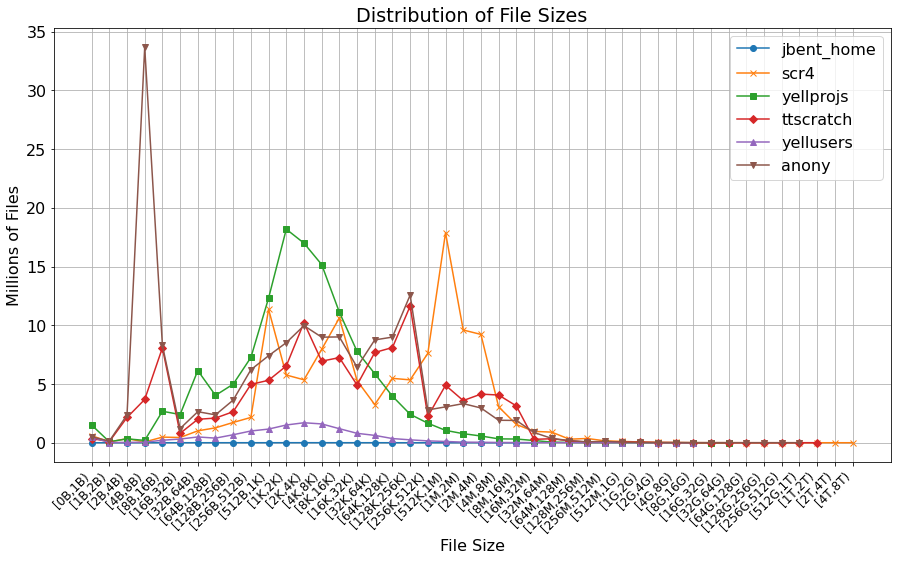

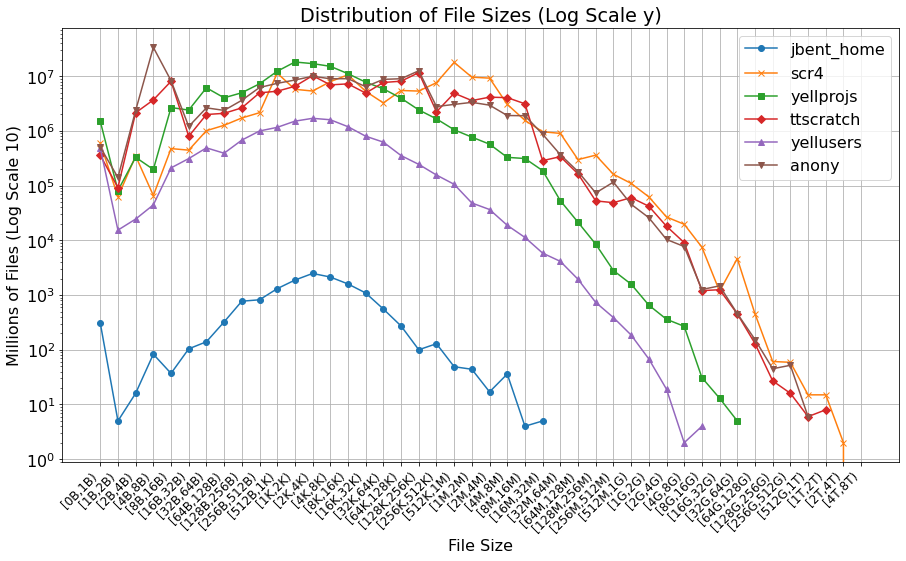

In [106]:
def frames_to_plt(dataframes,logscale=False):
    plt.figure(figsize=(15, 8))
    plt.rcParams['font.size'] = 16


    # Plot the data as a line graph
    markers = ['o', 'x', 's', 'D', '^', 'v']
    for idx, (indexroot, df) in enumerate(dataframes.items()):
        shortname = indexroot.rstrip('/').split("/")[-1]
        plt.plot(df['Range'], df['Num_Files'], marker=markers[idx], label=shortname)

    # y-tics are ugly, change them to be in values of millions
    def millions(x, pos):
        return f'{int(x/1e6)}'
    ax = plt.gca()
    formatter = FuncFormatter(millions)
    ax.yaxis.set_major_formatter(formatter)

    # Add labels and title
    plt.xlabel('File Size')
    plt.ylabel('Millions of Files')
    plt.title('Distribution of File Sizes')

    # avoid transparent background
    for item in (ax.figure, ax):
        item.set_facecolor('white')

    # Add grid and legend
    plt.grid(True)
    plt.legend()
    
    # x-axis is too crowded. Let's try to fix that.
    plt.xticks(rotation=45, ha='right')
    ax.tick_params(axis='x', labelsize=12)

    if logscale:
        # then add logscale and show it again
        ax.set_yscale('log')
        ax.set_title(ax.get_title() + " (Log Scale y)")
        ax.set_ylabel(ax.get_ylabel() + " (Log Scale 10)")
        
    return plt

plt = frames_to_plt(dataframes)
plt.show()
plt2 = frames_to_plt(dataframes,logscale=True)
plt2.show()